Nomes:

Otávio Terra Roque

Roberto Kazushi Yuuki Junior

In [ ]:
import cv2
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
%matplotlib inline  
%autosave 120
try:
    import vrep
except:
    print ('--------------------------------------------------------------')
    print ('"vrep.py" could not be imported. This means very probably that')
    print ('either "vrep.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "vrep.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
from IPython.display import clear_output
from IPython.display import display
import ctypes 

* Criando o mapa

In [4]:
def obstacles_grid(img):
    # Tratando a imagem e criando a mascara
    mask_wall = cv2.inRange(img, np.array([230,230,230]),
                              np.array([255,255,255]))
    mask_rim = cv2.inRange(img, 0, 0)
    mask_total = cv2.bitwise_or(mask_wall,mask_rim,mask_rim)
    mask_total = cv2.bitwise_not(mask_total)


    # Printando a imagem da camera e a mascara
    %matplotlib inline
    plt.imshow(img)
    plt.show()

    plt.imshow(mask_total, cmap="gray")
    plt.show()
    return mask_total

* Posicao e orientação do robo

In [6]:
#Pega a posição do disco que marca a frente do robô
def get_front_disk_position (img):
    front_disk_mask = cv2.inRange(img, np.array([100,140,205]), np.array([105,145,210]))
    contours, hierarchy = cv2.findContours(front_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])

#Pega a posição do disco que marca a traseira do robô
def get_back_disk_position (img):
    rear_disk_mask = cv2.inRange(img, np.array([75,185,185]), np.array([80,190,190]))    
    contours, hierarchy = cv2.findContours(rear_disk_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    return np.array([cY,cX])

#Com a parte da frente e traseira do robo pegamos a orientação
def get_robot_orientation(img):
    front_disk_position = get_front_disk_position (img)
    rear_disk_position =  get_back_disk_position (img)
    orientation = np.arctan2(rear_disk_position[1]-front_disk_position[1] , rear_disk_position[0]-front_disk_position[0])
    return orientation

In [7]:
#Função que defini a posição do robo
def get_robot_position(img):
    front_disk_position = get_front_disk_position (img)
    rear_disk_position =  get_back_disk_position (img)
    robot_pos = (front_disk_position+rear_disk_position)/2
    return tuple(robot_pos.astype('int'))

* Posição final

In [8]:
# Procura a posição da chegada (Quadrado verde)
def get_goal_position(img):
    goal_mask = cv2.inRange(img[:,:,1], 240, 255)
    goal_mask = cv2.GaussianBlur(goal_mask, (9, 9), 0)
    contours, hierarchy = cv2.findContours(goal_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

    return goal_mask, (cY,cX)

* Algoritmo A*

In [9]:
def search(grid,init,goal,cost, D = 1, D2 = 1):
    
    #calcula distancia
    def distancia_fnc(current_indx, goal_indx,D = 1):
        return np.sqrt( ( (current_indx[0]-goal_indx[0])**2 + (current_indx[1]-goal_indx[1])**2 ))
    
    hueristic_fnc = distancia_fnc
    
    
    def near_obstacles(point, half_kernel = 5):
        x_start = int(max(point[0] - half_kernel, 0))
        x_end = int(min(point[0] + half_kernel, grid.shape[0]))
        y_start = int(max(point[1] - half_kernel, 0))
        y_end = int(min(point[1] + half_kernel, grid.shape[1]))
        return np.any(grid[x_start:x_end, y_start:y_end]<128)
    
    def delta_gain(gain = 1):
        delta = np.array([[-1, 0],
                          [-1,-1],
                          [ 0,-1], 
                          [ 1,-1],
                          [ 1, 0], 
                          [ 1, 1],
                          [ 0, 1],        
                          [-1, 1]       
         ]) 
        return delta*gain
    
    delta = delta_gain(gain = 5)
    front = PriorityQueue()
    G = 0
    H = hueristic_fnc(init, goal, D)
    F = G+H
    front.put((F, G, init))
    discovered = []
    discovered.append(init)
    
    actions = np.ones_like(grid)*-1
    count = 0
    path = []
    
    def policy_draw(indx):
        indx_old = tuple(indx)
        indx_new = tuple(indx)
        path.append(tuple(goal))
        while indx_new != init:
            indx_new = tuple( np.array(indx_old) - delta[int(actions[indx_old])] )
            path.append(indx_new)
            indx_old = indx_new
    
        
    while not front.empty() :
        front_element = front.get()
        G = front_element[1]
        indx = front_element[2]
        if ((indx[0] >= goal[0]-20) and (indx[0] < goal[0]+20)) and ((indx[1] >= goal[1]-20) and (indx[1] < goal[1]+20)):
            policy_draw(indx)
            print("Encontrou o checkpoint")
            print(count)
            print(front_element)
            break 
        else:
            for y in range(len(delta)) :
                indx_new = tuple(indx + delta[y])
                if ((np.any(np.array(indx_new) < 0)) or (indx_new[0] > grid.shape[0]-1) or (indx_new[1] > grid.shape[1]-1)) :
                    continue
                if (grid[indx_new] >= 128) and (indx_new not in  discovered) :
                    count += 1
                    if near_obstacles(indx_new, half_kernel = 35):
                        g_new = G + 1500*cost
                    elif near_obstacles(indx_new, half_kernel = 70):
                        g_new = G + 15*cost
                    elif near_obstacles(indx_new, half_kernel = 100):
                        g_new = G + 10*cost
                    elif near_obstacles(indx_new, half_kernel = 110):
                        g_new = G + 5*cost
                    else:
                        g_new = G + cost
                    if y == actions[indx]:
                        g_new = g_new 
                    elif (y-1)%len(delta) == actions[indx] or (y+1)%len(delta) == actions[indx]:
                        g_new = g_new + 5*cost
                    else :
                        g_new = g_new + 10*cost
                    h_new = hueristic_fnc(indx_new, goal, D)
                    f_new = (g_new + h_new)-0.0001*count
                    front.put((f_new, g_new, indx_new))
                    discovered.append(indx_new)
                    actions[indx_new] = y        
    else:
        print(count)                               
    return actions, np.array(path[::-1])

* Funções úteis

In [10]:
def transform_points_from_image2real (points):
    if points.ndim < 2:
        flipped = np.flipud(points)
    else:
        flipped = np.fliplr(points)
    scale = 5/445
    points2send = (flipped*-scale) + np.array([2.0555+0.75280899, -2.0500+4.96629213])
    return points2send

In [11]:
def transform2robot_frame(pos, point, theta):
    pos = np.asarray(pos)
    point = np.asarray(point)
    T_matrix = np.array([
            [np.sin(theta), np.cos(theta)],
            [np.cos(theta), -1*np.sin(theta)],
            ])
    trans = point-pos
    if trans.ndim >= 2:
        trans = trans.T
        point_t = np.dot(T_matrix, trans).T
    else:
        point_t = np.dot(T_matrix, trans)
    return point_t

In [12]:
#Função que define se um ponto está perto do robo
def is_near(robot_center, point, dist_thresh = 0.25):
    dist = np.sqrt((robot_center[0]-point[0])**2 + (robot_center[1]-point[1])**2)
    return dist<=dist_thresh

In [13]:
#Função que retorna distancia entre dois pontos
def get_distance(points1, points2):
    return np.sqrt(np.sum(np.square(points1 - points2), axis=1))

In [14]:
#classe que define um controle PID
class pid():
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.error = 0.0
        self.error_old = 0.0
        self.error_sum = 0.0
        self.d_error = self.error - self.error_old
    def control(self,error):
        self.error = error
        self.error_sum += error
        self.d_error = self.error - self.error_old
        P = self.kp*self.error
        I = self.ki*self.error_sum
        D = self.kd*self.d_error
        self.error_old = self.error
        return P+I+D   

* Modelo do robo

As funções e constante abaixo se referem a como o robo é

In [15]:
d = 0.331 
r_w = 0.09751

In [16]:
def pioneer_robot_model(v_des, omega_des):
    v_r = (v_des+d*omega_des)
    v_l = (v_des-d*omega_des)
    omega_right = v_r/r_w
    omega_left = v_l/r_w
    return omega_right, omega_left

* * Rodando tudo

>> Conectando <<
0
>> Conectado <<
start 0


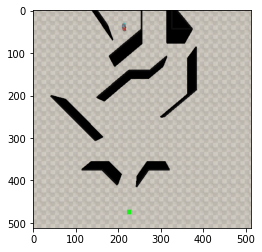

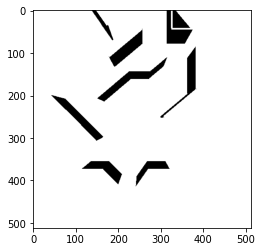

Encontrou o checkpoint
2636
(22224.16874902772, 22201, (489, 207))
[204 201 187 ... 205 198 183]
0.0967400074005127
[204 201 187 ... 205 198 183]
0.0967411994934082
[204 201 187 ... 205 198 183]
0.0967414379119873
[204 201 187 ... 205 198 183]
0.09873723983764648
[204 201 187 ... 205 198 183]
0.11021232604980469
[204 201 187 ... 205 198 183]
0.10172867774963379
[204 201 187 ... 205 198 183]
0.10272526741027832
[204 201 187 ... 205 198 183]
0.10671544075012207
[204 201 187 ... 205 198 183]
0.09574341773986816
[204 201 187 ... 205 198 183]
0.09674191474914551
[204 201 187 ... 205 198 183]
0.09773850440979004
[204 201 187 ... 205 198 183]
0.0967416763305664
[204 201 187 ... 205 198 183]
0.09773802757263184
[204 201 187 ... 205 198 183]
0.1029667854309082
[204 201 187 ... 205 198 183]
0.09873604774475098
[204 201 187 ... 205 198 183]
0.09526824951171875
[204 201 187 ... 205 198 183]
0.10073399543762207
[204 201 187 ... 205 198 183]
0.09474658966064453
[204 201 187 ... 205 198 183]
0.104235

In [40]:
import sim as vrep
lad = 0.5
print ('>> Conectando <<')
clientID=vrep.simxStart('127.0.0.1',18998,True,True,5000,5)
print(clientID)

if clientID!=-1:
    print ('>> Conectado <<')  
    e = vrep.simxStartSimulation(clientID,vrep.simx_opmode_blocking)
    print('start',e)
    try:
        # Conecta com os objetos da cena
        res,camera0_handle = vrep.simxGetObjectHandle(clientID,'top_view_camera',vrep.simx_opmode_oneshot_wait)
        res_l,right_motor_handle = vrep.simxGetObjectHandle(clientID,'Pioneer_p3dx_rightMotor',vrep.simx_opmode_oneshot_wait)
        res_r,left_motor_handle = vrep.simxGetObjectHandle(clientID,'Pioneer_p3dx_leftMotor',vrep.simx_opmode_oneshot_wait)
        res_las,look_ahead_sphere = vrep.simxGetObjectHandle(clientID,'look_ahead',vrep.simx_opmode_oneshot_wait)

        # Inicia constantes
        indx = 0
        err = 10
        theta = 0.0
        dt = 0.0
        count = 0
        om_sp = 0
        d_controller   = pid(kp=0.5, ki=0, kd=0)
        omega_controller = pid(0.5, 0., 0.)

        #Inicia
        while err != vrep.simx_return_ok:
            #Seta velocidade em 0 e pega imagem da camera
            tick = time.time()
            errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
            errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
            err,resolution,image=vrep.simxGetVisionSensorImage(clientID,camera0_handle,0,vrep.simx_opmode_streaming)
            
            #Inicia o processamento de imagem
            if err == vrep.simx_return_ok:
                #Converte imagem em um np.array e muda o tamanho
                img = np.array(image,dtype=np.uint8)
                img.resize([resolution[1],resolution[0],3])

                #Processa a imagem da camera para criar uma imagem para encontramos o robo e o alvo e detectar as paredes
                img_obs = obstacles_grid(img)
                
                #A partir da imagem original detecta a posição do robo
                center_robot = get_robot_position(img)

                #Da imagem original detecta onde está o checkpoint
                img_goal, center_goal = get_goal_position(img)

                #Procura o melhor caminho do robo ao checkpoint
                _ , newpath = search(img_obs,center_robot,center_goal,cost = 1, D = 1 )

                #Transforma os pontos de imagem que foram processados em pontos pro VREP             
                path_to_track = transform_points_from_image2real(newpath)
                tock = time.time()                
                dt = tock - tick
                center_goal = transform_points_from_image2real(np.array(center_goal))

        #Depois de traçar a rota inicia o deslocamento
        while not is_near(center_robot, center_goal, dist_thresh = 0.25):            
            tick = time.time()
            #Pega uma nova leitura da camera
            err,resolution,image=vrep.simxGetVisionSensorImage(clientID,camera0_handle,0,vrep.simx_opmode_streaming)   
            
            # Se conseguiu fazer a leitura     
            if err == vrep.simx_return_ok:
                #transforma a imagem em array
                img = np.array(image,dtype=np.uint8)
                print(img)
                img.resize([resolution[1],resolution[0],3])
                #Verifica a posição e orientação do robo e a distancia até o checkpoint
                center_robot = get_robot_position(img)
                center_robot = transform_points_from_image2real(np.array(center_robot))
                theta = get_robot_orientation(img)
                theta = np.arctan2(np.sin(theta), np.cos(theta))
                path_transformed = transform2robot_frame(center_robot, path_to_track, theta)
                dist = get_distance(path_transformed, np.array([0,0]))
                for i in range(dist.argmin(), dist.shape[0]):
                    if dist[i] < lad and indx <= i:
                        indx = i

                returnCode=vrep.simxSetObjectPosition(clientID,look_ahead_sphere,-1,(path_to_track[indx,0], path_to_track[indx,1], 0.005),vrep.simx_opmode_oneshot)
                orient_error = np.arctan2(path_transformed[indx,1], path_transformed[indx,0])
                #controla a velocidade do robo
                v_sp = d_controller.control(dist[indx])                     
                om_sp =omega_controller.control(orient_error)
                vr, vl = pioneer_robot_model(v_sp, om_sp)
                errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, vr, vrep.simx_opmode_oneshot)
                errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,vl, vrep.simx_opmode_oneshot)
                count += 1
                tock = time.time()                
                dt = tock - tick
                print(dt)
        else:
            print("Chegou!!")
            errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
            errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
    finally:
        errorCode_leftM = vrep.simxSetJointTargetVelocity(clientID, left_motor_handle, 0, vrep.simx_opmode_oneshot)
        errorCode_rightM = vrep.simxSetJointTargetVelocity(clientID, right_motor_handle,0, vrep.simx_opmode_oneshot)
        time.sleep(0.1)
        vrep.simxStopSimulation(clientID,vrep.simx_opmode_blocking)
        vrep.simxFinish(-1)